In [28]:
import os
import pandas as pd
import torch

from learning_models.sidarthe import Sidarthe
from populations import populations

from utils.data_utils import select_data
from utils.visualization_utils import generic_plot, Curve, generic_sub_plot, Plot, generate_format_xtick

from torch_euler import Heun
import json

In [2]:
# load targets
df_file = os.path.join(os.getcwd(), "COVID-19", "dati-andamento-nazionale", "dpc-covid19-ita-andamento-nazionale.csv")
area = ["ITA"]
area_col_name = "stato"  # "Country/Region"

groupby_cols = ["data"]  # ["Date"]

d_col_name = "isolamento_domiciliare"
r_col_name = "ricoverati_con_sintomi"
t_col_name = "terapia_intensiva"
h_detected_col_name = "dimessi_guariti"
e_col_name = "deceduti"  # "Fatalities"

x_target, d_target, dates = select_data(df_file, area, area_col_name, d_col_name, groupby_cols, file_sep=",")
_, y_target, _ = select_data(df_file, area, area_col_name, "totale_positivi", groupby_cols, file_sep=",")
_, r_target, _ = select_data(df_file, area, area_col_name, r_col_name, groupby_cols, file_sep=",")
_, t_target, _ = select_data(df_file, area, area_col_name, t_col_name, groupby_cols, file_sep=",")
_, h_detected_target, _ = select_data(df_file, area, area_col_name, h_detected_col_name, groupby_cols, file_sep=",")
_, e_target, _ = select_data(df_file, area, area_col_name, e_col_name, groupby_cols, file_sep=",")

initial_len = len(y_target)
tmp_d, tmp_r, tmp_t, tmp_h, tmp_e = [], [], [], [], []
for i in range(initial_len):
    if y_target[i] > 0:
        tmp_d.append(d_target[i])
        tmp_r.append(r_target[i])
        tmp_t.append(t_target[i])
        tmp_h.append(h_detected_target[i])
        tmp_e.append(e_target[i])
d_target = tmp_d
r_target = tmp_r
t_target = tmp_t
h_detected_target = tmp_h
e_target = tmp_e

targets = {
    "d": d_target,
    "r": r_target,
    "t": t_target,
    "h_detected": h_detected_target,
    "e": e_target
}


In [3]:
# load references
references = {}
param_keys = ['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'theta', 'xi', 'eta', 'mu', 'nu', 'tau', 'lambda', 'kappa', 'zeta', 'rho', 'sigma']
ref_df = pd.read_csv(os.path.join(os.getcwd(), "regioni", "sidarthe_results.csv"))
ref2_df = pd.read_csv(os.path.join(os.getcwd(), "regioni", "sidarthe_results_2.csv"))


for key in 'sidarthe':
    references[key] = ref_df[key][4:].tolist()

for key in ["h_detected"]:
    references[key] = ref_df[key][4:].tolist()

for key in ["r0"]:
    references[key] = ref_df[key][4:].tolist()

for key in param_keys:
    references[key] = ref_df[key][4:].tolist()


In [4]:
# load experiment values
exp_paths = os.path.join(os.getcwd(), "regioni", "sidarthe", "runs_84", "Italy")
exp_id = "05f48624-a181-4753-b736-cd8622d0995d"
exp_path = os.path.join(exp_paths, exp_id)
exp_settings_path = os.path.join(exp_path, "settings.json")
exp_report_path = os.path.join(exp_path, "final.json")

with open(exp_settings_path) as settings_json:
    exp_settings = json.load(settings_json)

with open(exp_report_path) as report_json:
    exp_report = json.load(report_json)

In [7]:
from pprint import pprint
# print hyper params and settings
print(exp_settings)

{'started': '07/August/2020 15:44:32', 'region': 'Italy', 'learning_rates': {'alpha': 1e-05, 'beta': 1e-06, 'gamma': 1e-05, 'delta': 1e-06, 'epsilon': 1e-05, 'theta': 1e-07, 'xi': 1e-05, 'eta': 1e-05, 'mu': 1e-05, 'nu': 1e-05, 'tau': 1e-07, 'lambda': 1e-05, 'kappa': 1e-05, 'zeta': 1e-05, 'rho': 1e-05, 'sigma': 1e-05}, 'target_weights': {'d_weight': 1.0, 'r_weight': 1.0, 't_weight': 1.0, 'h_weight': 1.0, 'e_weight': 0.0}, 'train_size': 84, 'val_len': 40, 'der_1st_reg': 41000.0, 't_inc': 1.0, 'momentum': True, 'm': 0.2, 'a': 0.04, 'integrator': 'Heun', 'loss_type': 'rmse', 'initial_values': {'alpha': [0.57, 0.57, 0.57, 0.57, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.422, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.2

In [8]:
# create trained model
population = populations["Italy"]
integrator = Heun
time_step = 1.

params = exp_report["params"]
train_size = exp_settings["train_size"]
val_size = exp_settings["val_len"]
dataset_size = len(x_target)

model_params = { 
    "d_weight": 1.,
    "r_weight": 1.,
    "t_weight": 1.,
    "h_weight": 1.,
    "e_weight": 1.,
    "der_1st_reg": 0.,
    "bound_reg": 0.,
    "verbose": False,
    "loss_type": "rmse",
    "references": references,
    "targets": targets,
    "train_size": train_size,
    "val_size": val_size,
    "first_date": dates[0]
}
init_conditions_params = { "population": population }
initial_conditions = Sidarthe.compute_initial_conditions_from_targets(targets, init_conditions_params)

model = Sidarthe(params, population, initial_conditions, integrator, time_step, **model_params)

In [9]:
# compute inference
with torch.no_grad():
    t_start = 0
    t_end = train_size

    t_grid = torch.linspace(0, dataset_size, int(dataset_size / time_step) + 1)
    inferences = model.inference(t_grid)

In [10]:
# print inital and final r0

print(f"Initial r0: {inferences['r0'][0]}")
print(f"Final r0: {inferences['r0'][-1]}")



Initial r0: 2.193898450264471
Final r0: 0.7660601568310422


In [11]:
# slice dataset
train_hat_slice = slice(t_start, int(train_size / time_step), int(1 / time_step))
val_hat_slice = slice(int(train_size / time_step), int(train_size + val_size / time_step),int(1 / time_step))
test_hat_slice = slice(int(train_size + val_size / time_step), int(dataset_size / time_step), int(1 / time_step))
dataset_hat_slice = slice(t_start, int(dataset_size / time_step), int(1 / time_step))

train_target_slice = slice(t_start, train_size, 1)
val_target_slice = slice(train_size, train_size + val_size, 1)
test_target_slice = slice(train_size + val_size, dataset_size, 1)
dataset_target_slice = slice(t_start, dataset_size, 1)

def slice_values(values, slice_):
    return {key: value[slice_] for key, value in values.items()}

hat_train = slice_values(inferences, train_hat_slice)
hat_val = slice_values(inferences, val_hat_slice)
hat_test = slice_values(inferences, test_hat_slice)
hat_dataset = slice_values(inferences, dataset_hat_slice)

target_train = slice_values(targets, train_target_slice)
target_val = slice_values(targets, val_target_slice)
target_test = slice_values(targets, test_target_slice)
target_dataset = slice_values(targets, dataset_target_slice)


references = { k: torch.tensor(v, dtype=model.dtype) for k,v in references.items() }

references_train = slice_values(references, train_target_slice)
references_val = slice_values(references, val_target_slice)
references_test = slice_values(references, test_target_slice)
references_dataset = slice_values(references, dataset_target_slice)

In [13]:
# compute losses of our model
our_train_risks = model.losses(
    hat_train,
    target_train
)

our_val_risks = model.losses(
    hat_val,
    target_val
)

our_test_risks = model.losses(
    hat_test,
    target_test
)

our_dataset_risks = model.losses(
    hat_dataset,
    target_dataset
)

In [14]:
# compute losses of nature sidarthe model
nature_train_risks = model.losses(
    references_train,
    target_train
)

nature_val_risks = model.losses(
    references_val,
    target_val
)

nature_test_risks = model.losses(
    references_test,
    target_test
)

nature_dataset_risks = model.losses(
    references_dataset,
    target_dataset
)

IndexError: The shape of the mask [40] at index 0does not match the shape of the indexed tensor [13] at index 0

In [15]:
# define utility funcs
def extend_param(value, length):
    len_diff = length - value.shape[0]
    if len_diff > 0:
        return torch.cat((value, value[-1].expand(len_diff)))
    else:
        return value

In [16]:
# print losses as bar plots
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator, MaxNLocator, FormatStrFormatter)
# temp redefine generic plot
width, height = 4,3
def generic_plot(xy_curves, title, save_path, x_label=None, y_label=None, formatter=None, use_legend=True, use_grid=True, close=True, grid_spacing=20, yaxis_sci=False):
    """

    :param xy_curves:
    :param title:
    :param x_label:
    :param y_label:
    :param formatter:
    :param save_path:
    :param use_legend:
    :param use_grid:
    :return:
    """

    fig, ax = plt.subplots()
    plt.title(title)
    plt.grid(use_grid)
    for curve in xy_curves:
        if curve.color is not None:
            ax.plot(curve.x, curve.y, curve.style, label=curve.label, color=curve.color)
        else:
            ax.plot(curve.x, curve.y, curve.style, label=curve.label)
    if formatter is not None:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(format_xtick))

    ax.xaxis.set_major_locator(MultipleLocator(grid_spacing))
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

    if x_label is not None:
        plt.xlabel(x_label)

    if y_label is not None:
        plt.ylabel(y_label)

    #ax.margins(0.05)
    if use_legend:
        ax.legend()

    """if yaxis_sci:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=None)"""

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', transparent=True)

    if close:
        plt.close('all')
    return fig

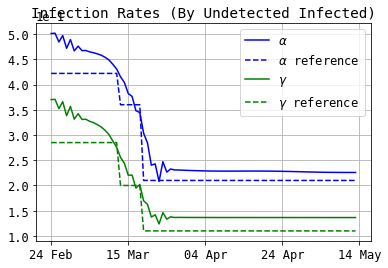

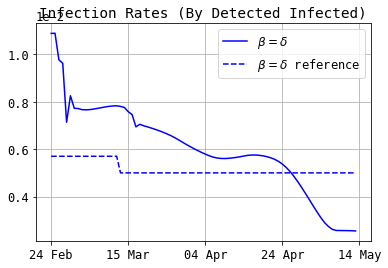

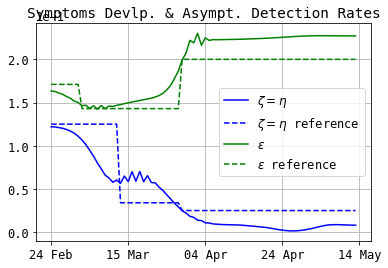

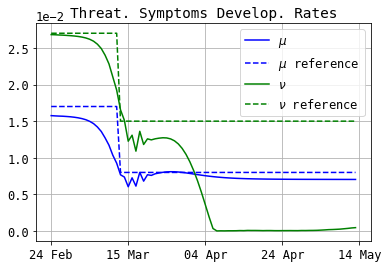

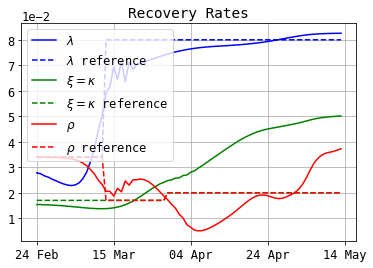

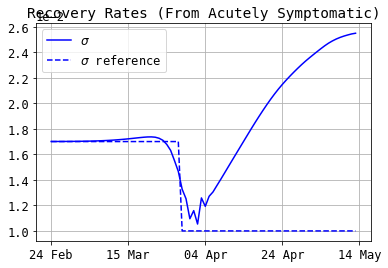

In [31]:
# get params plot

%matplotlib inline

file_format = ".pdf"
dpi = 144
bbox = 'tight'

max_len = 80

width=1.83
height=1.375
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.family': 'monospace'})
base_figures_path = os.path.join(exp_path, "figures")

format_xtick = generate_format_xtick(dates[0])

if not os.path.exists(base_figures_path):
        os.mkdir(base_figures_path)



def filename_from_title(title):
    filename = title.replace("$", "").replace("\\", "").replace(" ","_").replace(".", "")
    return filename + file_format

"""params_plots = model.plot_params_over_time()
for plot, plot_title in params_plots:
    filename = filename_from_title(plot_title)
    save_path = os.path.join(base_figures_path, filename)
    plot.savefig(save_path, bbox_inches=bbox, transparent=True)"""


colors = ["b", "g", "r", "c", "m"]
plot_groups = [
    ("Infection Rates (By Undetected Infected)", ("alpha", "gamma")),
    ("Infection Rates (By Detected Infected)", (("beta", "delta"),)),
    #("Detection Rates", ("epsilon", "theta")),
    ("Symptoms Devlp. & Asympt. Detection Rates", (("zeta","eta"), "epsilon")),
    ("Threat. Symptoms Develop. Rates", ("mu","nu")),
    #("Fatality Rate", ("tau",)),
    ("Recovery Rates", ("lambda", ("xi","kappa"), "rho")),
    ("Recovery Rates (From Acutely Symptomatic)", ("sigma",))
]


for plot_group in plot_groups:
    title, group_keys = plot_group
    #print(group_keys)
    pl_x = list(range(max_len))

    curves = []
    for param_keys, color in zip(group_keys, colors):
        if isinstance(param_keys, tuple):
            param_key = param_keys[0]
            latex_keys = [f"\\{key}" for key in param_keys]
            param_hat_legend = f"${' = '.join(latex_keys)}$"
        else:
            param_key = param_keys
            param_hat_legend = f"$\\{param_key}$"


        param = model.extend_param(model.params[param_key], max_len)
        param_hat_curve = Curve(pl_x, param[:max_len].detach().numpy(), '-', param_hat_legend, color) 
        
        param_ref_legend = f"{param_hat_legend} reference"
        param_ref_curve = Curve(pl_x, references[param_key][:max_len].numpy(), '--', param_ref_legend, color) 
        curves = curves + [param_hat_curve, param_ref_curve]
        #print(len(param_hat_curve.x))
        #print(len(param_ref_curve.x))
        
    filename = filename_from_title(title)
    save_path = os.path.join(base_figures_path, filename)
    plot = generic_plot(curves, title, save_path, formatter=format_xtick, yaxis_sci=True, close=False)


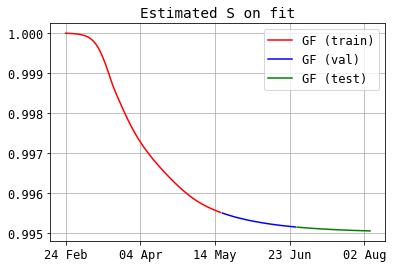

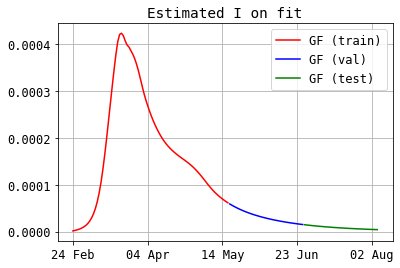

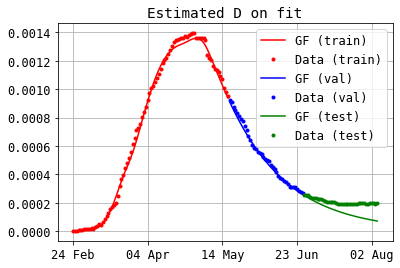

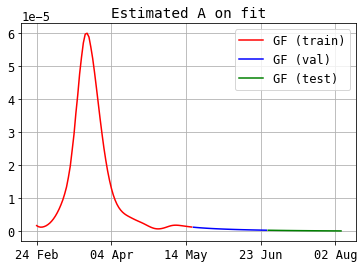

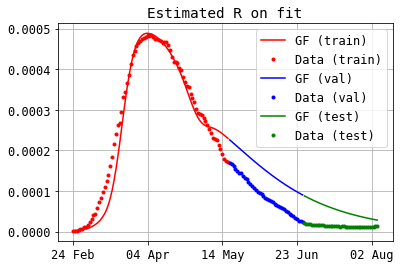

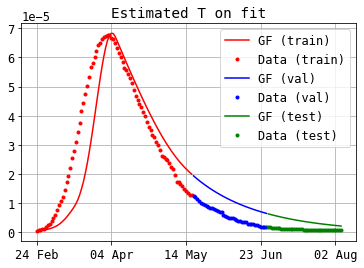

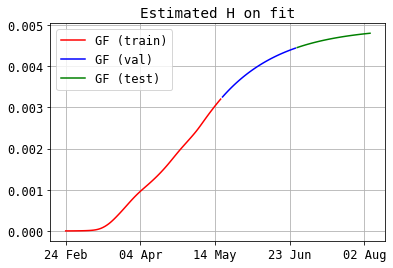

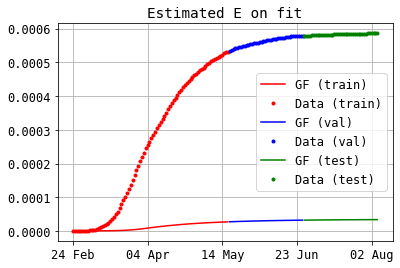

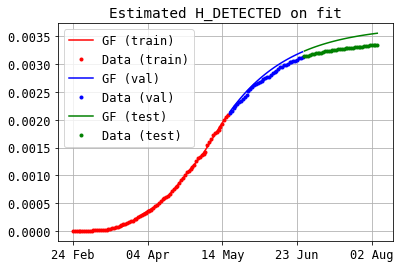

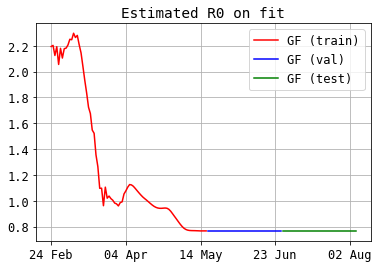

In [34]:
# plot fits

normalized_inferences = model.normalize_values(inferences, model.population)
norm_hat_train = slice_values(normalized_inferences, train_hat_slice)
norm_hat_val = slice_values(normalized_inferences, val_hat_slice)
norm_hat_test = slice_values(normalized_inferences, test_hat_slice)

normalized_targets = model.normalize_values(targets, model.population)
norm_target_train = slice_values(normalized_targets, train_target_slice)
norm_target_val = slice_values(normalized_targets, val_target_slice)
norm_target_test = slice_values(normalized_targets, test_target_slice)


train_range = range(0, train_size)
val_range = range(train_size, train_size + val_size)
test_range = range(train_size + val_size, dataset_size)
dataset_range = range(0, dataset_size)


for key in ["s", "i", "d", "a", "r", "t", "h", "e", "h_detected", "r0"]:
    if key != "r0":
        curr_hat_train = norm_hat_train[key]
        curr_hat_val = norm_hat_val[key]
        curr_hat_test = norm_hat_test[key]
    else:
        curr_hat_train = hat_train[key]
        curr_hat_val = hat_val[key]
        curr_hat_test = hat_test[key]

    if key in normalized_targets:
        target_train = norm_target_train[key]
        target_val = norm_target_val[key]
        target_test = norm_target_test[key]
    else:
        target_train = None
        target_val = None
        target_test = None

    train_curves = model.get_curves(train_range, curr_hat_train, target_train, "train", 'r')
    # print(f"{key}: {curr_hat_train.size}")
    val_curves = model.get_curves(val_range, curr_hat_val, target_val, "val", 'b')
    # print(f"{key}: {curr_hat_val.size}")
    test_curves = model.get_curves(test_range, curr_hat_test, target_test, "test", 'g')
    # print(f"{key}: {curr_hat_test.size}")

    tot_curves = train_curves + val_curves + test_curves

    if references is not None and False:
        reference_curve = Curve(list(dataset_range), references[key][dataset_target_slice], "--", label="Giordano et al.")
        tot_curves = tot_curves + [reference_curve]

    
    pl_title = f"Estimated {key.upper()} on fit"
    filename = filename_from_title(pl_title)
    save_path = os.path.join(base_figures_path, filename)
    
    plt.rcParams.update({'font.size': 12})
    fig = generic_plot(tot_curves, pl_title, save_path, formatter=format_xtick, yaxis_sci=True, close=False, grid_spacing=40)
    

In [24]:
# print losses as latex table

table_str = ""


# print header
keys = "drth"
header = " & Train & Valid. & Test & Total"
header += "\\\\ \\hline"
print(header)
table_str += header + "\n"

def get_risk_sum(risks):
    total = 0.
    for key in keys: 
        d_key = f"{key}_rmse"
        error = risks[d_key]
        total += error
    return total
    
def get_risks_row(risks, row, bold=False):
    pre = "\\textbf{" if bold else ""
    post = "}" if bold else ""

    for risk in risks:
        row = row + " & " + pre + f"{risk:.1f}" + post
    return row + "\\\\"

get_nature_results = False


if get_nature_results:
    # print Giordano values#print our values
    train_risk = get_risk_sum(nature_train_risks)
    val_risk = get_risk_sum(nature_val_risks)
    test_risk = get_risk_sum(nature_test_risks)
    dataset_risk = get_risk_sum(nature_dataset_risks)
    risks = (train_risk, val_risk, test_risk, dataset_risk)

    row = get_risks_row(risks, "\cite{Giordano2020}")
    print(row)
    table_str += row

    align_str = "\\noalign{\\smallskip}"
    print(align_str)
    table_str += align_str + "\n"

#print our values
train_risk = get_risk_sum(our_train_risks)
val_risk = get_risk_sum(our_val_risks)
test_risk = get_risk_sum(our_test_risks)
dataset_risk = get_risk_sum(our_dataset_risks)
risks = (train_risk, val_risk, test_risk, dataset_risk)

row = get_risks_row(risks, "GF", bold=True)
row += " \\bottomrule"
print(row)
table_str += row



& Train & Valid. & Test & Total\\ \hline
GF & \textbf{3743.6} & \textbf{6692.5} & \textbf{12209.9} & \textbf{7911.9}\\ \bottomrule


In [25]:
with open(os.path.join(exp_path, "error_table.txt"), "w+") as table_file:
    table_file.write(table_str)    
